In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import fipy as fp
from fipy.tools.dump import read
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
from fvm_utils import *
import torch

print(torch.cuda.is_available())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True


# Hybrid parameter estimation: linear regression and neural networks

Inspired by some scribbles on a Zoom whiteboard with Danny Seara, see below

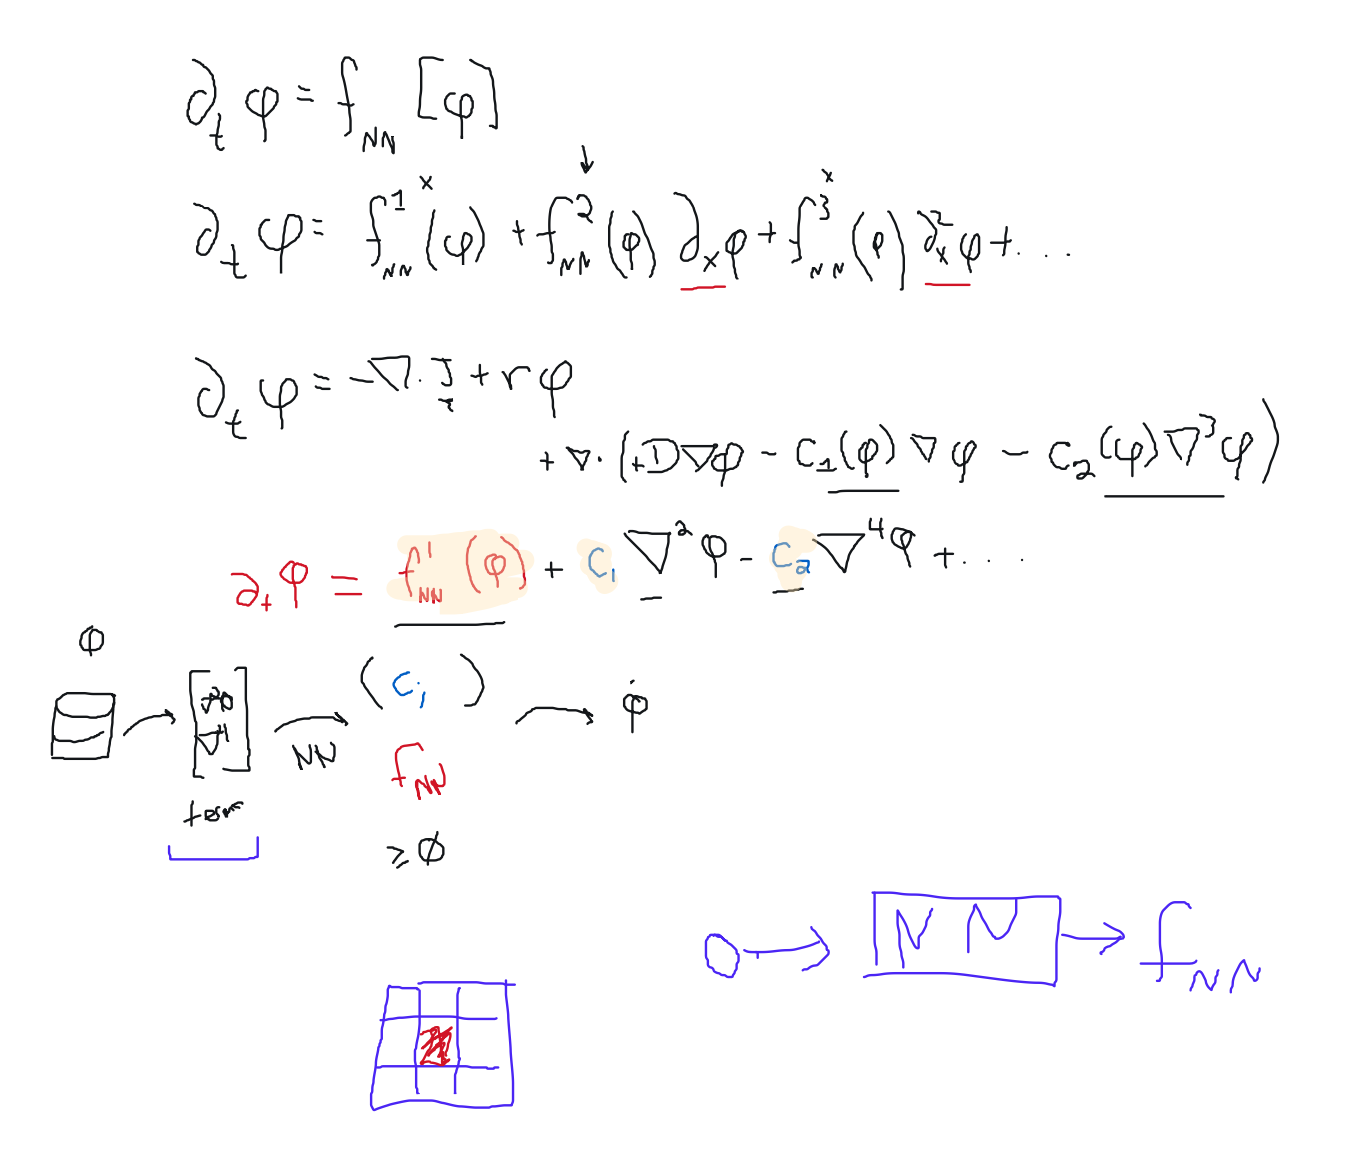

Pre-loading all Fipy data from files
Done (t = 3.9 s)
W0_mesh (776,)
B0_mesh (776,)
W1_mesh (776,)
B1_mesh (776,)
t0 ()
t1 ()
features_mesh List of length 2
X torch.Size([776])
Y torch.Size([776])
W0 (776,)
B0 (776,)
W1 (776,)
B1 (776,)
features torch.Size([2, 7, 776])
dt_W (776,)
dt_B (776,)
inputs torch.Size([2, 776])
targets torch.Size([2, 776])


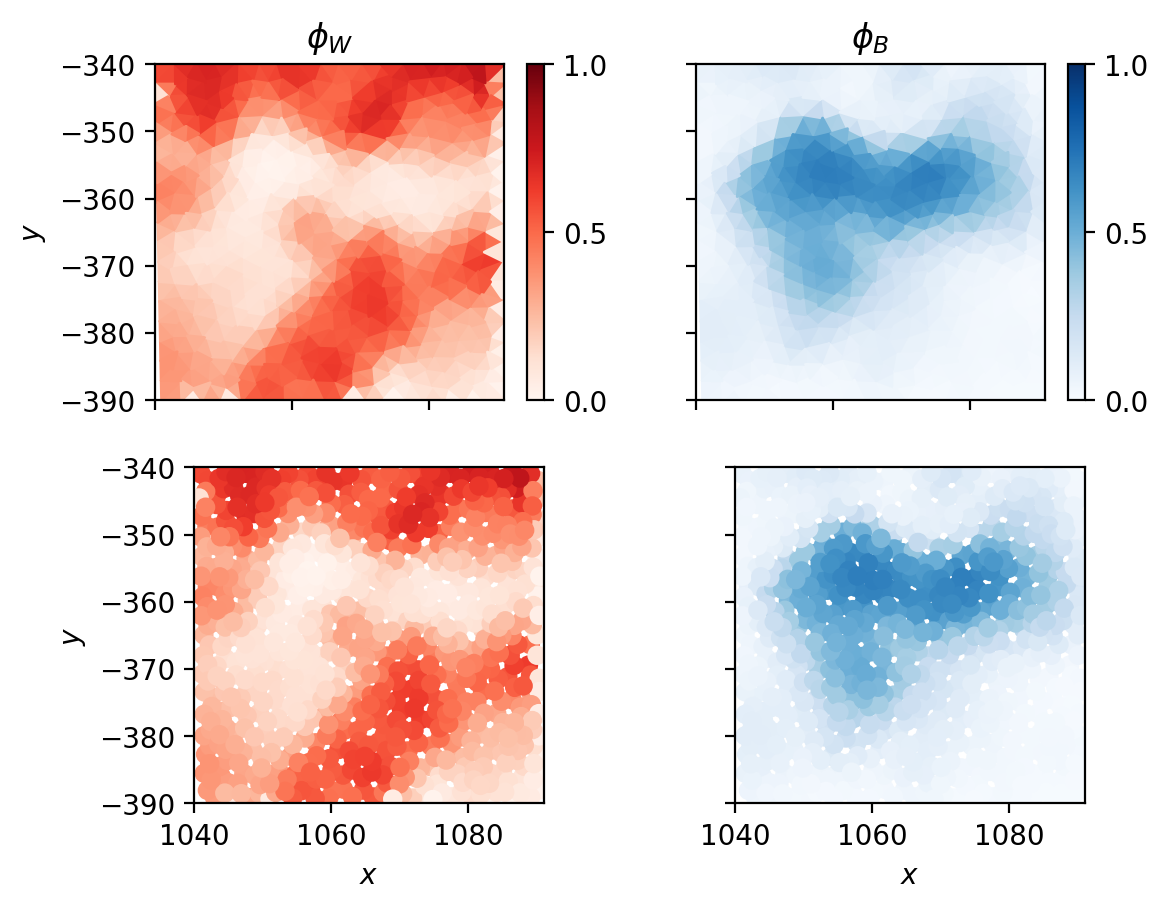

In [15]:
from fipy_dataset import FipyDataset

dataset = FipyDataset(grid=False, remove_extra=False, preload=True)
sample = dataset[5]

for key in sample:
    try:
        print(key, sample[key].shape)
    except:
        if isinstance(sample[key], list):
            print(key, 'List of length', len(sample[key]))
        else:
            print(key, sample[key])

# Plot everything to make sure that things look correct
from fvm_utils import plot_mesh
fig, ax = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True)

# Plot original fipy objects
plot_mesh(sample['W0_mesh'], sample['W0_mesh'].mesh, ax[0, 0], cmap=plt.cm.Reds, vmin=0, vmax=1)
plot_mesh(sample['B0_mesh'], sample['B0_mesh'].mesh, ax[0, 1], cmap=plt.cm.Blues, vmin=0, vmax=1)

# Plot 
try:
    ax[1, 0].pcolormesh(sample['X'], sample['Y'], sample['inputs'][0], cmap='Reds', vmin=0, vmax=1)
    ax[1, 1].pcolormesh(sample['X'], sample['Y'], sample['inputs'][1], cmap='Blues', vmin=0, vmax=1)
except:
    ax[1, 0].scatter(sample['X'], sample['Y'], c=sample['inputs'][0], cmap='Reds', vmin=0, vmax=1)
    ax[1, 1].scatter(sample['X'], sample['Y'], c=sample['inputs'][1], cmap='Blues', vmin=0, vmax=1)

ax[0, 0].set_title('$\\phi_W$')
ax[0, 1].set_title('$\\phi_B$')

ax[0, 0].set_ylabel('$y$')
ax[1, 0].set(xlabel='$x$', ylabel='$y$')
ax[1, 1].set_xlabel('$x$')

for a in ax.flatten():
    a.set_aspect(np.ptp(a.get_ylim()) / np.ptp(a.get_xlim()))

In [16]:
from fipy_nn import SociohydroParameterNetwork, ParameterNetwork
model = SociohydroParameterNetwork()
model.print()

outputs, _ = model(sample['inputs'], sample['features'], batched=False)
print(outputs.shape)                                 

dt ϕW = 1 T_W + 0 k_WW + 0 k_WB + 0 ν_WWW + 0 ν_WWB + 0 ν_WBB + -1 Γ_W + NN(['ϕW', 'ϕB'])
dt ϕB = 1 T_B + 0 k_BB + 0 k_BW + 0 ν_BBB + 0 ν_BWB + 0 ν_BWW + -1 Γ_B + NN(['ϕW', 'ϕB'])
torch.Size([2, 776])


In [31]:
from train_fipy_nn import JointLossFunction

loss = JointLossFunction(beta=1.)

loss(sample['targets'][None],
     sample['targets'][None],
     sample['inputs'][None],
     sample['inputs'][None],
     sample['inputs'][None])

torch.Size([776, 2])
torch.Size([1, 776, 2])
torch.Size([1, 2, 776])


tensor(0.4695)

# Analyze a trained model

{'alpha': 1.0,
 'base_lr': 0.0003,
 'batch_size': 32,
 'beta': 0.0,
 'coef_lr': 0.1,
 'county': 'Georgia_Fulton',
 'epochs': 100,
 'grid': False,
 'scheduler_step': 0.98,
 'val_split': 0.5}
dt ϕW = 0.34 T_W + -1.2 k_WW + 0.97 k_WB + -1.1 ν_WWW + -1.3 ν_WWB + 1.2 ν_WBB + -0.35 Γ_W + NN(['ϕW', 'ϕB'])
dt ϕB = 0.39 T_B + 0.3 k_BB + -0.052 k_BW + 0.98 ν_BBB + -0.78 ν_BWB + 0.22 ν_BWW + -0.6 Γ_B + NN(['ϕW', 'ϕB'])


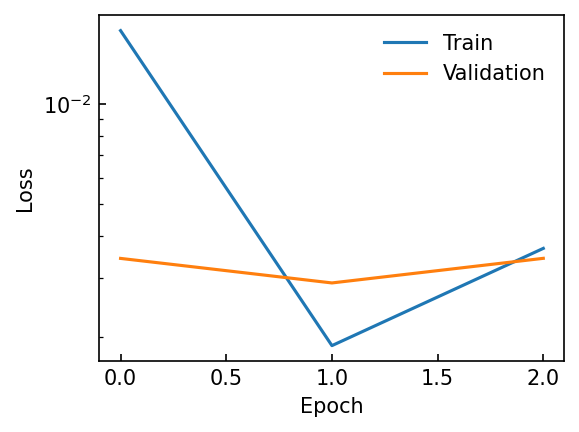

In [44]:
from fipy_nn import SociohydroParameterNetwork
import yaml
from pprint import pprint

model_dir = 'models/Georgia_Fulton_noGrid_SociohydroParameterNetwork_200824_1630'
with open(f'{model_dir}/config.yml', 'r') as file:
    config = yaml.safe_load(file)

info = torch.load(f'{model_dir}/model.ckpt', map_location='cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SociohydroParameterNetwork(grid=config['grid']).to(device)
model.load_state_dict(info['state_dict'])
model.eval();

pprint(config)

model.print()


fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
ax.plot(info['train_loss'], label='Train')
ax.plot(info['val_loss'], label='Validation')
ax.legend(framealpha=0.)
ax.set(xlabel='Epoch', ylabel='Loss', yscale='log')
ax.tick_params(which='both', direction='in')

Fipy data files will be read in at runtime


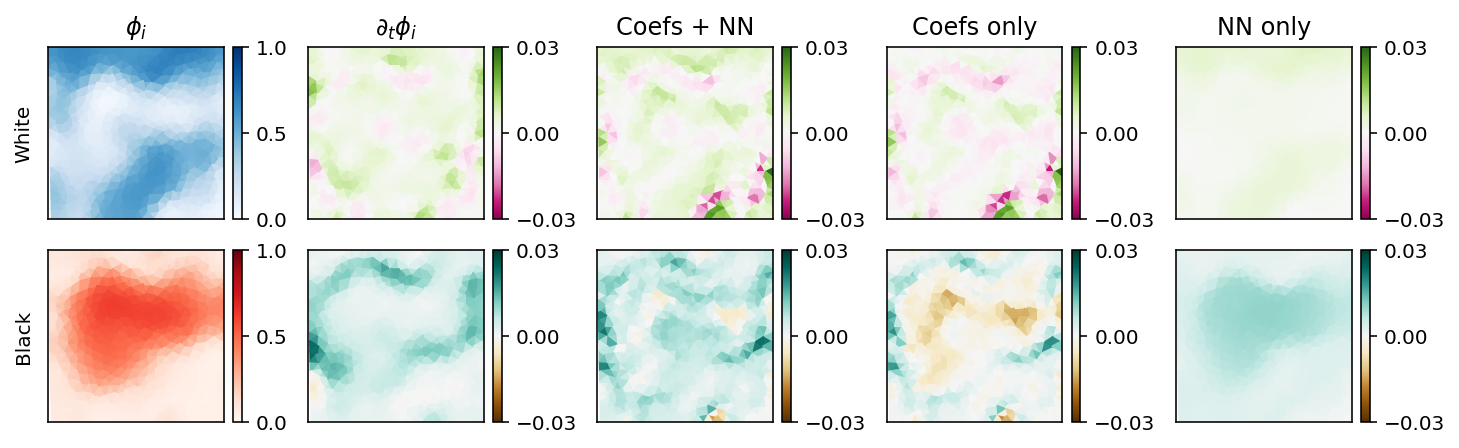

In [38]:
from fipy_dataset import FipyDataset
from fvm_utils import plot_mesh

dataset = FipyDataset(grid=config['grid'], remove_extra=False)
sample = dataset[100]

with torch.no_grad():
    outputs, (feature_terms, growth)= model(
        sample['inputs'].to(device), sample['features'].to(device), batched=False)

    inputs = sample['inputs'].cpu().numpy()
    targets = sample['targets'].cpu().numpy()
    outputs = outputs.cpu().numpy()
    feature_terms = feature_terms.cpu().numpy()
    growth = growth.cpu().numpy()

mesh = sample['W0_mesh'].mesh

fig, ax = plt.subplots(2, 5, sharey=True, sharex=True, constrained_layout=True, dpi=144, figsize=(10, 3))
plot_mesh(inputs[0], mesh, ax[0, 0],
          cmap=plt.cm.Blues, vmin=0, vmax=1)
plot_mesh(inputs[1], mesh, ax[1, 0],
          cmap=plt.cm.Reds, vmin=0, vmax=1)

vmax = 0.03

plot_mesh(targets[0], mesh, ax[0, 1],
          cmap=plt.cm.PiYG, vmin=-vmax, vmax=vmax)
plot_mesh(targets[1], mesh, ax[1, 1],
          cmap=plt.cm.BrBG, vmin=-vmax, vmax=vmax)

plot_mesh(outputs[0], mesh, ax[0, 2],
          cmap=plt.cm.PiYG, vmin=-vmax, vmax=vmax)
plot_mesh(outputs[1], mesh, ax[1, 2],
          cmap=plt.cm.BrBG, vmin=-vmax, vmax=vmax)

plot_mesh(feature_terms[0], mesh, ax[0, 3],
          cmap=plt.cm.PiYG, vmin=-vmax, vmax=vmax)
plot_mesh(feature_terms[1], mesh, ax[1, 3],
          cmap=plt.cm.BrBG, vmin=-vmax, vmax=vmax)

plot_mesh(growth[0], mesh, ax[0, 4],
          cmap=plt.cm.PiYG, vmin=-vmax, vmax=vmax)
plot_mesh(growth[1], mesh, ax[1, 4],
          cmap=plt.cm.BrBG, vmin=-vmax, vmax=vmax)

ax[0, 0].set(ylabel="White", title=r"$\phi_i$")
ax[1, 0].set(ylabel="Black")
ax[0, 1].set(title=r"$\partial_t \phi_i$")
ax[0, 2].set(title=r"Coefs + NN")
ax[0, 3].set(title=r"Coefs only")
ax[0, 4].set(title=r"NN only")

for a in ax.ravel():
    a.set_aspect(1)
    a.set(xticks=[], yticks=[])

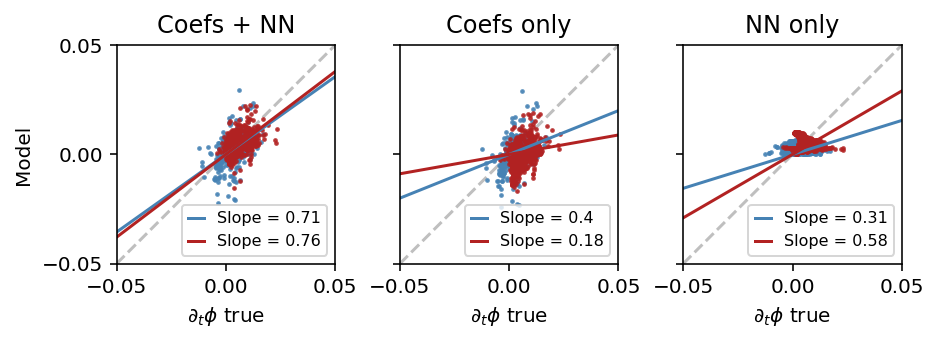

In [39]:
from sklearn.linear_model import LinearRegression

def scatter_plot(ax, x, y, title='', s=2, alpha=0.8, lim=0.05):
    # Scatterplot
    ax.scatter(x[0], y[0], color='steelblue', s=s, alpha=alpha)
    ax.scatter(x[1], y[1], color='firebrick', s=s, alpha=alpha)

    # Linear fits
    xx = np.linspace(-lim, lim, 2)
    fitter = LinearRegression(fit_intercept=False)

    fitter.fit(x[0,:,None], y[0,:,None])
    yy = fitter.predict(xx[:,None])
    ax.plot(xx, yy, color='steelblue', label=f'Slope = {fitter.coef_[0,0]:.2g}')

    fitter.fit(x[1,:,None], y[1,:,None])
    yy = fitter.predict(xx[:,None])
    ax.plot(xx, yy, color='firebrick', label=f'Slope = {fitter.coef_[0,0]:.2g}')

    # Formatting and legend
    ticks = [-lim, 0, lim]
    ax.set(
        xlim=[-lim, lim], xticks=ticks, xlabel=r'$\partial_t \phi$ true',
        ylim=[-lim, lim], yticks=ticks,
        title=title, aspect=1
    )
    ax.plot(ticks, ticks, color='gray', alpha=0.5, linestyle='--', zorder=-10)
    ax.legend(loc='lower right', handlelength=1, fontsize=8)

fig, ax = plt.subplots(1, 3, dpi=144, sharex=True, sharey=True, constrained_layout=True)

scatter_plot(ax[0], targets, outputs, 'Coefs + NN')
ax[0].set_ylabel('Model')

scatter_plot(ax[1], targets, feature_terms, 'Coefs only')
scatter_plot(ax[2], targets, growth, 'NN only')

(ϕW)' = 0.002 ϕW + 0.008 ϕW^2 + 0.003 ϕB^2
(ϕB)' = -0.001 1 + 0.023 ϕW + 0.008 ϕB + -0.028 ϕW^2 + -0.011 ϕW ϕB + 0.013 ϕB^2


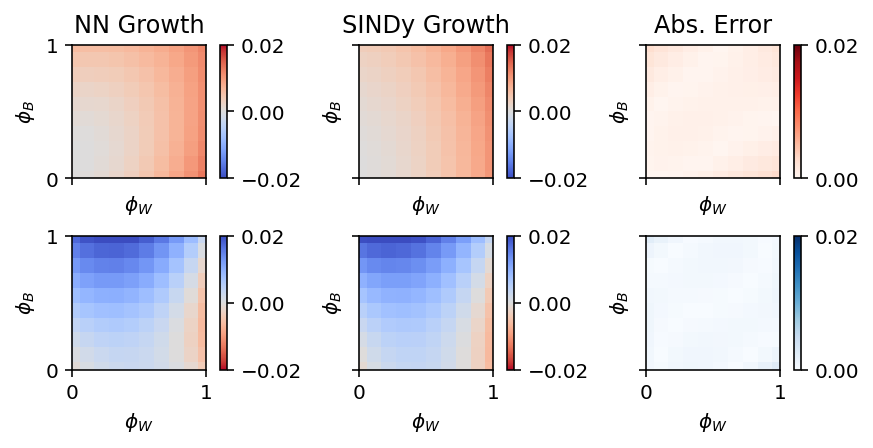

In [40]:
import pysindy as ps
N = 10
phi = np.linspace(0, 1, N)
phiWB = np.stack(np.meshgrid(phi, phi))
phiWB = phiWB.reshape([2, -1])

with torch.no_grad():
    nn_out = model.local_network(torch.cuda.FloatTensor(phiWB)).cpu().numpy()

sindy = ps.SINDy(
    optimizer=ps.STLSQ(threshold=1e-2, normalize_columns=True),
    feature_library=ps.PolynomialLibrary(degree=2),
    feature_names=['ϕW', 'ϕB'],
)
sindy.fit(x=phiWB.T, x_dot=nn_out.T)
sindy.print()
sindy_out = sindy.predict(phiWB.T).T

phiWB = phiWB.reshape([2, N, N])
nn_out = nn_out.reshape([2, N, N])
sindy_out = sindy_out.reshape([2, N, N])

vmax = 0.02

fig, ax = plt.subplots(2, 3, dpi=144, figsize=(6, 3),
                       sharex=True, sharey=True, constrained_layout=True)
c = ax[0,0].pcolormesh(phiWB[0], phiWB[1], nn_out[0], cmap='coolwarm', vmin=-vmax, vmax=vmax)
fig.colorbar(c, ax=ax[0,0], ticks=[-vmax, 0, vmax])
c = ax[1,0].pcolormesh(phiWB[0], phiWB[1], nn_out[1], cmap='coolwarm_r', vmin=-vmax, vmax=vmax)
fig.colorbar(c, ax=ax[1,0], ticks=[-vmax, 0, vmax])
ax[0,0].set_title('NN Growth')

c = ax[0,1].pcolormesh(phiWB[0], phiWB[1], sindy_out[0], cmap='coolwarm', vmin=-vmax, vmax=vmax)
fig.colorbar(c, ax=ax[0,1], ticks=[-vmax, 0, vmax])
c = ax[1,1].pcolormesh(phiWB[0], phiWB[1], sindy_out[1], cmap='coolwarm_r', vmin=-vmax, vmax=vmax)
fig.colorbar(c, ax=ax[1,1], ticks=[-vmax, 0, vmax])
ax[0,1].set_title('SINDy Growth')

c = ax[0,2].pcolormesh(phiWB[0], phiWB[1], np.abs(nn_out[0]-sindy_out[0]), cmap='Reds', vmin=0, vmax=vmax)
fig.colorbar(c, ax=ax[0,2], ticks=[0, vmax])
c = ax[1,2].pcolormesh(phiWB[0], phiWB[1], np.abs(nn_out[1]-sindy_out[1]), cmap='Blues', vmin=0, vmax=vmax)
fig.colorbar(c, ax=ax[1,2], ticks=[0, vmax])
ax[0,2].set_title('Abs. Error')

for a in ax.ravel():
    a.set(
        xlabel=r'$\phi_W$', xlim=[0,1], xticks=[0,1],
        ylabel=r'$\phi_B$', ylim=[0,1], yticks=[0,1],
        aspect=1,
    )


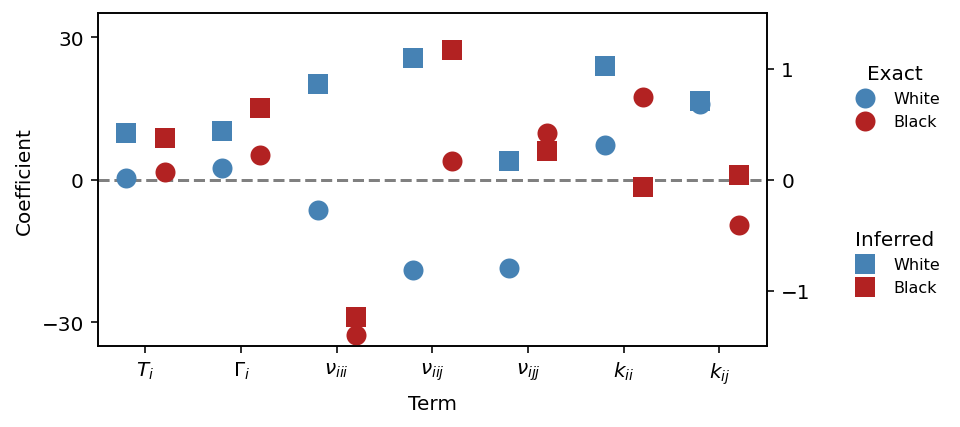

In [41]:
import json
import seaborn as sns
import pandas as pd

# Load exact parameters
paramfile = f"./data/{config['county']}_small/{config['county']}_small_NYCinferredParams_params.json"
with open(paramfile) as f:
    params = json.load(f)

# Put everything into a dataframe
W_df = pd.DataFrame({
    'term':  ['$T_i$', '$\Gamma_i$', r'$\nu_{iii}$', r'$\nu_{iij}$', r'$\nu_{ijj}$', '$k_{ii}$', '$k_{ij}$'],
    'coef': [params['tempW'], params['gammaW'], params['nuWWW'], params['nuWWB'], params['nuWBB'], params['kWW'], params['kWB']],
})
W_df['target'] = 'White'

B_df = pd.DataFrame({
    'term':  ['$T_i$', '$\Gamma_i$', r'$\nu_{iii}$', r'$\nu_{iij}$', r'$\nu_{ijj}$', '$k_{ii}$', '$k_{ij}$'],
    'coef': [params['tempB'], params['gammaB'], params['nuBBB'], params['nuBWB'], params['nuBWW'], params['kBB'], params['kBW']],
}) 
B_df['target'] = 'Black'

true_df = pd.concat([W_df, B_df])

# Collect NN parameters
with torch.no_grad():
    coefs = model.get_coefs().detach().cpu().numpy()

# Put everything into a dataframe
W_df = pd.DataFrame({
    'term':  ['$T_i$', '$\Gamma_i$', r'$\nu_{iii}$', r'$\nu_{iij}$', r'$\nu_{ijj}$', '$k_{ii}$', '$k_{ij}$'],
    'coef': -coefs[0, [0, 6, 3, 4, 5, 1, 2]],
})
W_df.loc[0, 'coef'] *= -1
W_df['target'] = 'White'

B_df = pd.DataFrame({
    'term':  ['$T_i$', '$\Gamma_i$', r'$\nu_{iii}$', r'$\nu_{iij}$', r'$\nu_{ijj}$', '$k_{ii}$', '$k_{ij}$'],
    'coef': -coefs[1, [0, 6, 3, 4, 5, 1, 2]],
})
B_df.loc[0, 'coef'] *= -1
B_df['target'] = 'Black'

ml_df = pd.concat([W_df, B_df])

#Put it all together and plot
total_df = pd.concat([true_df, ml_df])

fig, ax = plt.subplots(1, 1, dpi=144, figsize=(6, 3))
sns.stripplot(
    data=true_df,
    x='term',
    y='coef',
    hue='target',
    palette=['steelblue', 'firebrick'],
    dodge=True,
    s=10, marker='o',
    ax=ax,
)
sns.move_legend(ax, loc='center left', bbox_to_anchor=[1.1, 0.75], 
                framealpha=0., title='Exact', fontsize=8)

ax2 = ax.twinx()
sns.stripplot(
    data=ml_df,
    x='term',
    y='coef',
    hue='target',
    palette=['steelblue', 'firebrick'],
    dodge=True,
    s=10, marker='s',
    ax=ax2,
)
sns.move_legend(ax2, loc='center left', bbox_to_anchor=[1.1, 0.25], 
                framealpha=0., title='Inferred', fontsize=8)


ax.axhline(0, color='grey', linestyle='--', zorder=-1)
ax.set(ylim=[-35, 35], yticks=[-30, 0, 30], ylabel='Coefficient', xlabel='Term')
ax2.set(ylim=[-1.5, 1.5], yticks=[-1, 0, 1], ylabel=None);
